In [ ]:


import numpy as np 
import pandas as pd 



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

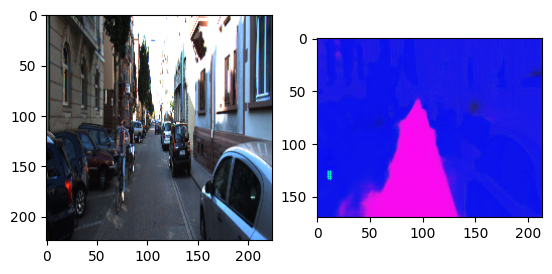

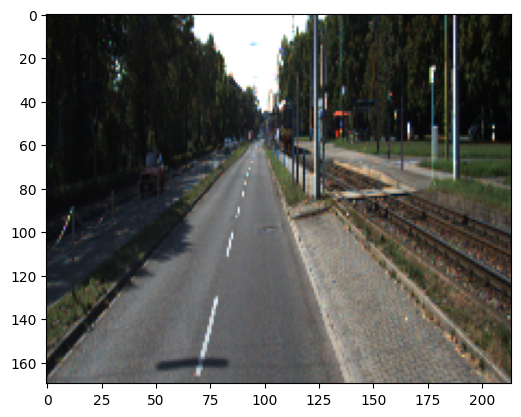

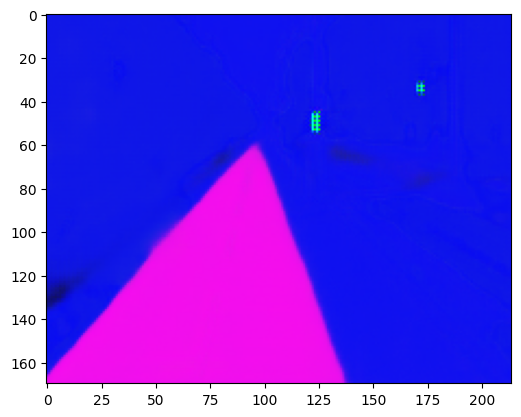

In [24]:
import numpy as np
import cv2
import glob
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from torch_snippets import Report

# Install torch_snippets if not installed
!pip install torch_snippets
from torch_snippets import *

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define transformations
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Get file paths
train_images = sorted(glob.glob("/kaggle/input/kitti-roadlane-detection-dataset-224-x-224/data_road_224/training/image_2/*.png"))
train_mask = sorted(glob.glob("/kaggle/input/kitti-roadlane-detection-dataset-224-x-224/data_road_224/training/gt_image_2/*.png"))
test_images = sorted(glob.glob("/kaggle/input/kitti-roadlane-detection-dataset-224-x-224/data_road_224/testing/image_2/*.png"))

# Define dataset class
class SegData(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        image = cv2.imread(self.images[ix])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        mask = cv2.imread(self.labels[ix])
        mask = cv2.resize(mask, (224, 224))
        return image, mask
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([transforms.ToTensor()(mask)[None] for mask in masks]).float().to(device)
        return ims, ce_masks

# Create dataset and dataloader
train_dataset = SegData(train_images, train_mask)
trn_dl = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)

# Define convolution and up-convolution blocks
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), padding="same"),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# Define the TinyUNet model
class TinyUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = conv(3, 64)
        self.block2 = conv(64, 64)
        self.block3 = conv(64, 128)
        self.block4 = conv(128, 128)
        self.block5 = conv(128, 256)
        self.block6 = conv(256, 256)
        self.block7 = conv(256, 512)
        self.block8 = conv(512, 512)
        self.block9 = conv(512, 1024)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0, dilation=1, ceil_mode=False)
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 256, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 128, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 64, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(64, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.maxpool(self.block2(block1))
        block3 = self.block3(block2)
        block4 = self.maxpool(self.block4(block3))
        block5 = self.block5(block4)
        block6 = self.maxpool(self.block6(block5))
        block7 = self.block7(block6)
        block8 = self.maxpool(self.block8(block7))
        block9 = self.block9(block8)

        x4 = self.up_conv6(block9)
        x4 = torch.cat([x4, block7], dim=1)
        x4 = self.conv6(x4)
        x3 = self.up_conv7(x4)
        
        x3 = torch.cat([x3, block5], dim=1)
        x3 = self.conv7(x3)

        x2 = self.up_conv8(x3)
        x2 = torch.cat([x2, block3], dim=1)
        x2 = self.conv8(x2)

        x1 = self.up_conv9(x2)
        x1 = torch.cat([x1, block1], dim=1)
        x1 = self.conv9(x1)

        x = self.sigmoid(self.conv11(x1))

        return x

# Create an instance of the model
model = TinyUNet().to(device)
summary(model, (3, 224, 224))

# Define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)

# Define training and validation functions
def train_batch(model, data):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss = loss_fn(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(model, data):
    model.eval()
    ims, masks = data
    masks = model(ims)
    loss = loss_fn(masks, masks)
    return loss.item()

# Define number of epochs and create a report
n_epochs = 20
log = Report(n_epochs)

# Training loop
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss = train_batch(model, data)
        log.record(ex + (bx + 1) / N, trn_loss=loss, end='\r')
    log.report_avgs(ex + 1)

# Process test image and visualize the result
image = cv2.imread(test_images[-7])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image_tensor = tfms(image / 255.)[None].float().to(device)

# Predict lanes
with torch.no_grad():
    mask = model(image_tensor)

mask = mask[0].detach().permute(1, 2, 0).cpu()
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask)

PATH = "Kitty_lane_detector.pt"
torch.save(model.state_dict(), PATH)

# Extract region of interest and process it
mask_img = np.round(255 * mask.numpy()).astype(np.uint8)
roi = mask_img[50:220, 10:, :]
image = image[50:220, 10:, :]

plt.imshow(roi)
plt.figure()
plt.imshow(image)

mask_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(mask_gray, (5, 5), 0)
ret, thresh = cv2.threshold(mask_gray, 100, 255, cv2.THRESH_BINARY)
canny = cv2.Canny(np.array(thresh, dtype=np.uint8), 50, 255, apertureSize=7)
canny = cv2.dilate(canny, np.ones((5, 5)), iterations=1)

plt.imshow(canny)

# Apply Hough transform to detect lines
lines = cv2.HoughLinesP(canny, 2, np.pi/180, threshold=100, lines=np.array([]), minLineLength=40, maxLineGap=5)

# Draw detected lines on the image
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:
            lanes = cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2, cv2.LINE_AA)
    plt.imshow(lanes)
else:
    print("There are no lines detected")

# Define functions to make and average coordinates
def make_coordinates(coords):
    y = image.shape[0]
    y2 = int(y * (3 / 5))
    m, b = coords[0], coords[1]
    x = (y - b) / m
    x2 = (y2 - b) / m
    return np.array([x, y, x2, y2])

def average_lines(lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_average = np.average(left_fit, axis=0)
    right_average = np.average(right_fit, axis=0)
    left_coords = make_coordinates(left_average)
    right_coords = make_coordinates(right_average)
    return np.array([left_coords, right_coords], dtype=np.int32)

# Average detected lines and draw them on the image
avg_line = average_lines(lines)

if avg_line is not None:
    for line in avg_line:
        x1, y1, x2, y2 = line.reshape(4)
        lanes = cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2, cv2.LINE_AA)
    plt.imshow(lanes)
else:
    print("There are no lines detected")

# Compute and print steering angle
def compute_steering_angle(avg_line, image):
    h, w = image.shape[:2]
    if avg_line is not None and len(avg_line) == 2:
        theta = 0
        _, _, x1, _ = avg_line[0]
        _, _, x2, _ = avg_line[1]
        theta = theta + np.arctan(((x2 + x1) / 2 - int(w / 2)) / int(h * (3 / 5)))
        rad = np.rad2deg(theta) + 90
    elif avg_line is None:
        theta = 0
        theta = theta + np.arctan2(0, int(h / 2))
        rad = np.rad2deg(theta)
    else:
        theta = 0
        for line in avg_line:
            x1, y1, x2, y2 = line
            theta = theta + np.arctan((x2 - x1) / (y2 - y1))
        rad = np.rad2deg(theta) + 90
    print(rad - 90)
    print(theta)

compute_steering_angle(avg_line, image)

# Define a function to predict lanes and display results
def predict_lanes(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image_tensor = tfms(image / 255.)[None].float().to(device)
    with torch.no_grad():
        mask = model(image_tensor)
    mask = mask[0].detach().permute(1, 2, 0).cpu()
    mask_img = np.round(255 * mask.numpy()).astype(np.uint8)
    roi = mask_img[50:220, 10:, :]
    image = image[50:220, 10:, :]
    mask_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(mask_gray, (5, 5), 0)
    ret, thresh = cv2.threshold(mask_gray, 100, 255, cv2.THRESH_BINARY)
    canny = cv2.Canny(np.array(thresh, dtype=np.uint8), 50, 255, apertureSize=7)
    canny = cv2.dilate(canny, np.ones((5, 5)), iterations=1)
    lines = cv2.HoughLinesP(canny, 2, np.pi / 180, threshold=100, lines=np.array([]), minLineLength=40, maxLineGap=5)
    avg_line = average_lines(lines)
    if avg_line is not None:
        for line in avg_line:
            x1, y1, x2, y2 = line.reshape(4)
            lanes = cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3, cv2.LINE_AA)
        plt.imshow(lanes)
    else:
        print("There is no line")
    plt.figure()
    plt.imshow(roi)
    compute_steering_angle(avg_line, image)

# Test the predict_lanes function with a sample test image
image = cv2.imread(test_images[1])
predict_lanes(image)
